# Application Work Sample, Unacast Summer Internship 2019

In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/Oda/google_service_account_key.json'

%load_ext google.cloud.bigquery
%matplotlib inline

## 1. What day of week has the most rides in 2014?

In [129]:
%%bigquery weekday_counts

SELECT FORMAT_DATE('%A', DATE(pickup_datetime)) AS weekday,
       COUNT(*) AS count
FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2014`
GROUP  BY weekday
ORDER  BY count DESC

,weekday,count
0,Saturday,25395046
1,Friday,24908598
2,Wednesday,24199625
3,Thursday,24118335
4,Tuesday,22880639
5,Sunday,22352100
6,Monday,21260018


The results tell us that **Saturday** is the day of the week with most rides in 2014. We can visualize the data with a simple bar plot:

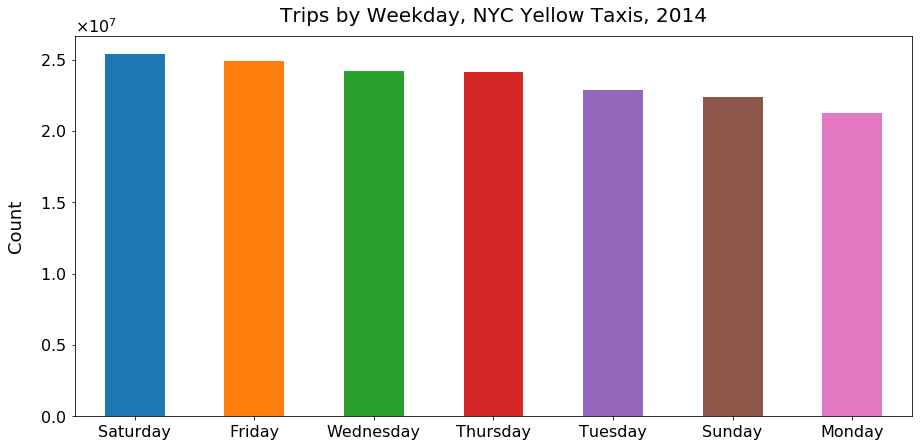

In [258]:
ax = weekday_counts.plot(kind='bar', x='weekday', y='count', figsize=(15,7), legend=False, rot=0)
ax.yaxis.get_major_formatter().set_useMathText(True)
ax.yaxis.offsetText.set_fontsize(16)
ax.tick_params(labelsize='16', pad=5)

ax.set_title('Trips by Weekday, NYC Yellow Taxis, 2014', y=1.02, size=20)
ax.set_xlabel('')
ax.set_ylabel('Count', labelpad=15, size=18);

## 2. How has the ratio of payments in cash and by credit card developed over time?

We'll be looking at all the available yellow taxi trip records – datasets from 2009 and onwards. Since we're only interested in the relationship between the two payment types, I'm also including this year's dataset (2018). Although there is only data available for the first half of the year, it seems reasonable to assume that the reported data is complete, so that the payment type ratio will be representative. 

The payment type is listed in the `payment_type` column in all datasets. Let's have a quick look at how the payment types are specified.

In [270]:
%%bigquery

SELECT payment_type 
       
FROM   (SELECT payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2009`
        
        UNION DISTINCT
        
        SELECT payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2010`
        
        UNION DISTINCT
        
        SELECT payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2011`
        
        UNION DISTINCT
        
        SELECT payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2012`
        
        UNION DISTINCT
        
        SELECT payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2013`
        
        UNION DISTINCT
        
        SELECT payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2014`
        
        UNION DISTINCT
        
        SELECT payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2015`
        
        UNION DISTINCT
        
        SELECT payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2016`
        
        UNION DISTINCT
        
        SELECT payment_type
        FROM   `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2017`
        
        UNION DISTINCT
        
        SELECT payment_type
        FROM   `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`
        )
        
ORDER  BY LOWER(payment_type)

,payment_type
0,1
1,2
2,3
3,4
4,5
5,CAS
6,Cas
7,CASH
8,Cash
9,CRD


We need to do some gentle data cleaning since card and cash payments are specified in several ways, both across and within the individual datasets. The table schema informs that "1" signifies credit card payment and "2" signifies cash payment. 

I've chosen a simple approach of grouping the data by years, instead of a higher resolution of quarterly, monthly or even weekly grouping. This will be good enough for our aim of viewing the general development of card vs. cash payment over time. 

In [85]:
%%bigquery payments

SELECT year,
       COUNT(CASE
             WHEN LOWER(payment_type) IN ('credit', 'crd', 'cre', '1') THEN 1
             END) AS card,
       COUNT(CASE
             WHEN LOWER(payment_type) IN ('cash', 'csh', 'cas', '2') THEN 1
             END) AS cash
       
FROM   (SELECT 2009 AS year,
               payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2009`
        
        UNION ALL
        
        SELECT 2010 AS year,
               payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2010`
        
        UNION ALL
        
        SELECT 2011 AS year,
               payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2011`
        
        UNION ALL
        
        SELECT 2012 AS year,
               payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2012`
        
        UNION ALL
        
        SELECT 2013 AS year,
               payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2013`
        
        UNION ALL
        
        SELECT 2014 AS year,
               payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2014`
        
        UNION ALL
        
        SELECT 2015 AS year,
               payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2015`
        
        UNION ALL
        
        SELECT 2016 AS year,
               payment_type
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2016`
        
        UNION ALL
        
        SELECT 2017 AS year,
               payment_type
        FROM   `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2017`
        
        UNION ALL
        
        SELECT 2018 AS year,
               payment_type
        FROM   `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2018`
        )

WHERE  LOWER(payment_type) IN ('credit', 'crd', 'cre', '1',
                                 'cash', 'csh', 'cas', '2')
GROUP  BY year
ORDER  BY year

,year,card,cash
0,2009,44891981,125400096
1,2010,61615664,107056564
2,2011,76320383,100576816
3,2012,86157354,91904363
4,2013,93334004,79110096
5,2014,95571321,68167680
6,2015,91574644,53864648
7,2016,86187728,44241313
8,2017,76244327,36479462
9,2018,44129396,18799613


Let's calculate the percentage of card payments per year:

In [224]:
payments['card_%'] = 100 * payments['card'] / (payments['card'] + payments['cash'])
payments

,year,card,cash,card_%
0,2009,44891981,125400096,26.361756
1,2010,61615664,107056564,36.529822
2,2011,76320383,100576816,43.143918
3,2012,86157354,91904363,48.386231
4,2013,93334004,79110096,54.124208
5,2014,95571321,68167680,58.368086
6,2015,91574644,53864648,62.964171
7,2016,86187728,44241313,66.080167
8,2017,76244327,36479462,67.638187
9,2018,44129396,18799613,70.125681


We can visualize this development with a simple line chart.

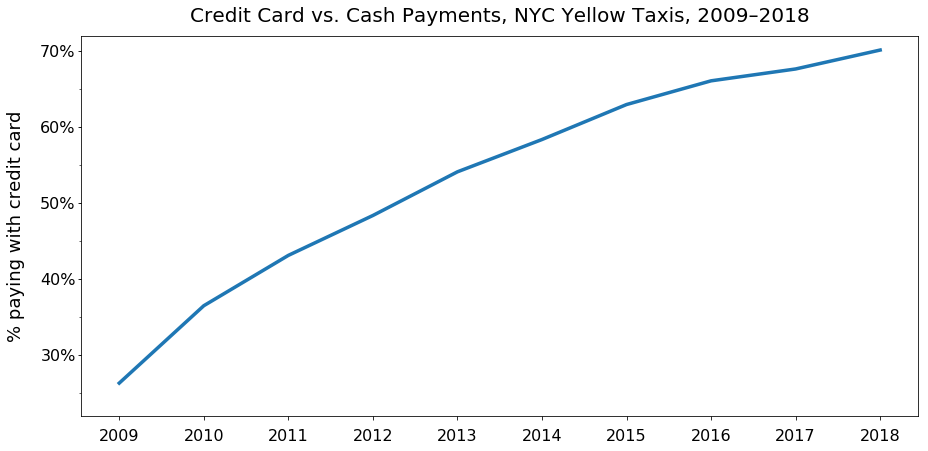

In [259]:
ax = payments.plot(x='year', y='card_%', figsize=(15,7), legend=False, linewidth='3.5', 
                   xticks=(list(range(2009, 2019))), 
                   yticks=list(range(20, 75, 10)), ylim=([22,72]))
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=False))
ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
ax.tick_params('x', labelsize='16', pad=9)
ax.tick_params('y', labelsize='16', pad=2)

ax.set_title('Credit Card vs. Cash Payments, NYC Yellow Taxis, 2009–2018', y=1.02, size=20)
ax.set_xlabel('')
ax.set_ylabel('% paying with credit card', labelpad=15, size=18);

Payment by credit card surpassed cash in 2012, and has increased steadily from about a quarter of all payments in 2009 to 7 in 10 payments in 2018.

## 3. What is the most popular area to be picked up in 2014?  (disregarding airports)

First, we need to get the coordinates of the trips made in 2014. The dataset provides latitudes and longitudes with a degree precision of more than 12 decimal places, an unnecessarily high precision, considering that this represents coordinates precise to micrometers and that GPS positioning in New York is challenging due to the tall skyscrapers. 

We are only interested in a ballpark estimate, not millimeter (or micrometer!) precision. I'm going to round off the precision of the latitudes and longitudes to three decimal places, in order to lump together the pickup locations which are reasonably close to one another. 

I'm also going to limit the query to the top 1,000 coordinates, since we are only interested in the most popular areas. 

In [263]:
%%capture # To avoid cluttering the notebook with a long list
%%bigquery trip_coordinates

SELECT coordinates, COUNT(coordinates) as count
FROM   (SELECT CONCAT(CAST(ROUND(pickup_latitude, 3) AS STRING), 
                      ',', 
                      CAST(ROUND(pickup_longitude, 3) AS STRING)) AS coordinates
        FROM   `bigquery-public-data.new_york.tlc_yellow_trips_2014`)
GROUP   BY coordinates
ORDER   BY count DESC
LIMIT   1000

Let's take a peek at the results.

In [264]:
trip_coordinates.head(10)

,coordinates,count
0,"0,0",3285189
1,"40.751,-73.994",768879
2,"40.75,-73.991",668680
3,"40.774,-73.871",640367
4,"40.75,-73.992",638670
5,"40.645,-73.782",582516
6,"40.769,-73.863",575531
7,"40.774,-73.873",559239
8,"40.757,-73.99",442105
9,"40.756,-73.991",408523


Apparently a good portion of the trips do not have a pickup location recorded. We'll discard that first row. The rest of the table remains fairly cryptic without looking up each individual coordinate. To get a good feel for the data, we'll create a heatmap.

First, we'll simply extract the latitudes and longitudes to two separate columns:

In [265]:
coordinates = trip_coordinates['coordinates'].str.split(',', n=1, expand=True)
trip_coordinates['lat'] = coordinates[0].astype('float')
trip_coordinates['lon'] = coordinates[1].astype('float')
trip_coordinates = trip_coordinates[1:] # Skip first row 

And now we're ready to have a look at the most popular pickup locations.

In [26]:
import gmaps
API_KEY = 'AIza...''
gmaps.configure(api_key=API_KEY)

In [269]:
locations = trip_coordinates[['lat', 'lon']]
weights = trip_coordinates['count']
fig = gmaps.figure(map_type='HYBRID', zoom_level=11, center=(40.72, -73.92))
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
# Map not interactive in published notebook

![New York](map-0.png)

Clearly the airports and Manhattan have the most pickups. Zooming in on Manhattan shows that **Midtown is the most popular area**. 

<img src="manhattan.png" align="left" />

However, can we get even more specific? Let's limit our view to the top 20 pickup locations to get a clearer picture of what the most popular pickup locations in Midtown are.

In [268]:
locations = trip_coordinates[['lat', 'lon']][:20]
weights = trip_coordinates['count'][:20]
fig = gmaps.figure(map_type='SATELLITE', zoom_level=13, center=(40.753, -73.99))
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
# Map not interactive in published notebook

![Manhattan](map-1.png)

And there we have it. The most popular pickup locations in Midtown are, not surprisingly, the main public transportation terminals:

* **Pennsylvania Station**
* **Grand Central Terminal**
* **42 St - Port Authority Bus Terminal**

Two areas outside of Midtown and the airports are included in the top 20 locations – the Central Park entrance at  Columbus Circle and the hip and trendy Meatpacking District. If we further limit the view to the top 10 locations, these are no longer included.